In [2]:
# %%
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentparentdir)

# %%
import pandas as pd
import random
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign

from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from copy import copy
from visualization.visualization import draw_BN, draw_comparative_hist, get_probability
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from core.core_utils import project_root
from external.pyBN.utils.independence_tests import mutual_information, entropy, mi_from_en
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
import seaborn as sns
import sklearn.metrics as skm
import scipy.stats as ss
from scipy.spatial.distance import cdist
from external.libpgm.sampleaggregator import SampleAggregator
from sklearn.metrics import accuracy_score, mean_squared_error
import operator
from typing import Tuple
import json5
from bayesian.sampling import generate_synthetics
from graph.precision_recall import child_dict
from visualization.visualization import get_probability, grouped_barplot
from bayesian.calculate_accuracy import parall_accuracy
import time
import itertools

In [3]:
df1 = pd.read_csv('caregorized.csv')
df2 = pd.read_csv('noncaregorized.csv')

In [6]:
print(list(df1.columns))
print(list(df2.columns))

['total_bilirubin_mean', 'triglycerides_mean', 'creatinine_mean', 'potassium_mean', 'AST_mean', 'ALT_mean', 'sodium_mean', 'total_protein_mean', 'HDL_mean', 'hba1c_mean', 'LDL_mean', 'cholesterol_mean', 'AC_mean', 'hemoglobin_mean', 'hematocrit_mean', 'leukocytes_mean', 'CAD_mean', 'DAD_mean', 'bmi_mean', 'arterial_hypertension', 'essential_hypertension', 'CHF', 'COPD', 'atherosclerosis', 'anemia', 'APC', 'CKD', 'harmful_lifestyle', 'AF', 'IGT', 'metabolic_syndrome', 'obesity', 'stenocardia', 'sleep_disorders', 'DLM', 'hyperglycemia', 'diabetic_osteoarthropathy', 'diabetic_ulcer', 'thyrotoxicosis', 'hypocorticism', 'acromegaly', 'ischemic_cardiomyopathy', 'myocardial_infarction', 'CHD', 'ACS', 'diabetic_retinopathy', 'diabetic_angiopathy', 'diabetic_nephropathy', 'neuropathy', 'cushing_syndrome', 'stroke', 'insulins', 'all_gipoglemic_drugs', 'all_statins', 'diuretic', 'beta_block']
['total_bilirubin_mean', 'triglycerides_mean', 'creatinine_mean', 'potassium_mean', 'AST_mean', 'ALT_mean

In [ ]:
full_dict = dict()
with open(f'{currentdir}/log_full.txt', 'r') as log:
    for i, line in enumerate(log):
        if i % 3 == 0:
            large = line.rstrip()
        elif i % 3 == 1:
            col_new = json5.loads(' '.join(line.split(' ')[1:]).rstrip())
        else:
            time_long = float(line.split(' ')[-1].rstrip())
            flag = True
            for key in full_dict:
                if set(json5.loads(key)) == set(col_new):
                    full_dict[key].append(time_long)
                    flag = False
            if flag:
                full_dict[str(col_new)] = [time_long]

In [16]:
coded_dict = dict()   
with open(f'{currentdir}/log_coded.txt', 'r') as log:
    for i, line in enumerate(log):
        if i % 4 == 0:
            large = line.rstrip()
        elif i % 4 == 1:
            alpha = float(line.rstrip())
        else:
            if i % 4 == 2:
                col_new = json5.loads(' '.join(line.split(' ')[1:]).rstrip())
            else:
                time_long = float(line.split(' ')[-1].rstrip())
                flag = True
                for key in coded_dict:
                    if set(json5.loads(key)) == set(col_new):
                        coded_dict[key].append([alpha, time_long])
                        flag = False
                if flag:
                    coded_dict[str(col_new)] = [[alpha, time_long]]

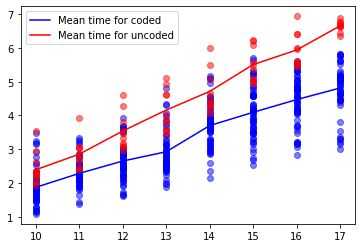

In [24]:
x = []
y = []
mid = dict()
for key, value in coded_dict.items():
    for el in value:
        large = len(json5.loads(key))
        x.append(large)
        y.append(el[1])
        if len(json5.loads(key)) in mid:
            mid[large].append(el[1])
        else:
            mid[large] = [el[1]]
plt.scatter(x, y, c ="blue", alpha = 0.5)
x = sorted(list(mid.keys()))
y = [np.mean(mid[large]) for large in x]
plt.plot(x, y, c ="blue", label = 'Mean time for coded')

x = []
y = []
mid = dict()
for key, value in full_dict.items():
    for el in value:
        large = len(json5.loads(key))
        x.append(large)
        y.append(el)
        if len(json5.loads(key)) in mid:
            mid[large].append(el)
        else:
            mid[large] = [el]
plt.scatter(x, y, c ="red", alpha = 0.5)
x = sorted(list(mid.keys()))
y = [np.mean(mid[large]) for large in x]
plt.plot(x, y, c ="red", label = 'Mean time for uncoded')
plt.legend()

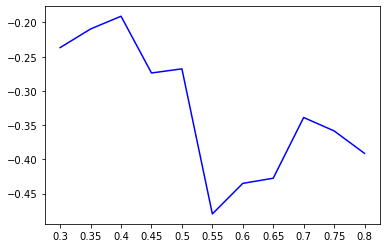

In [30]:
x = []
y = []
mid_time = dict()
for key, value in full_dict.items():
    for el in value:
        if key in mid_time:
            mid_time[key].append(el)
        else:
            mid_time[key] = [el]
mid_time = {key: np.mean(value) for key, value in mid_time.items()}
# plt.scatter(x, y, c ="red", alpha = 0.5)
# x = sorted(list(mid.keys()))
# y = [np.mean(mid[large]) for large in x]
# plt.plot(x, y, c ="red", label = 'Mean time for uncoded')

x = []
y = []
mid = dict()
for key, value in coded_dict.items():
    for el in value:
        large = len(json5.loads(key))
        x.append(el[0])
        y.append(el[1]/mid_time[key] - 1.0)
        if len(json5.loads(key)) in mid:
            mid[str(el[0])].append(el[1]/mid_time[key] - 1.0)
        else:
            mid[str(el[0])] = [el[1]/mid_time[key] - 1.0]
#plt.scatter(x, y, c ="blue", alpha = 0.5)
x = sorted(list(mid.keys()))
y = [np.mean(mid[large]) for large in x]
plt.plot(x, y, c ="blue", label = 'Mean time for coded')


In [35]:
full_dict = dict()
with open(f'{currentdir}/log_full_vk.txt', 'r') as log:
    for i, line in enumerate(log):
        if i % 3 == 0:
            large = line.rstrip()
        elif i % 3 == 1:
            col_new = json5.loads(' '.join(line.split(' ')[1:]).rstrip())
        else:
            time_long = float(line.split(' ')[-1].rstrip())
            flag = True
            for key in full_dict:
                if set(json5.loads(key)) == set(col_new):
                    full_dict[key].append(time_long)
                    flag = False
            if flag:
                full_dict[str(col_new)] = [time_long]

In [36]:
coded_dict = dict()   
with open(f'{currentdir}/log_coded_vk.txt', 'r') as log:
    for i, line in enumerate(log):
        if i % 4 == 0:
            large = line.rstrip()
        elif i % 4 == 1:
            alpha = float(line.rstrip())
        else:
            if i % 4 == 2:
                col_new = json5.loads(' '.join(line.split(' ')[1:]).rstrip())
            else:
                time_long = float(line.split(' ')[-1].rstrip())
                flag = True
                for key in coded_dict:
                    if set(json5.loads(key)) == set(col_new):
                        coded_dict[key].append([alpha, time_long])
                        flag = False
                if flag:
                    coded_dict[str(col_new)] = [[alpha, time_long]]

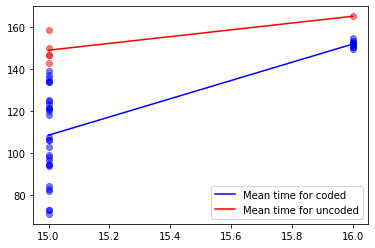

In [37]:
x = []
y = []
mid = dict()
for key, value in coded_dict.items():
    for el in value:
        large = len(json5.loads(key))
        if large > 10:
            x.append(large)
            y.append(el[1])
            if len(json5.loads(key)) in mid:
                mid[large].append(el[1])
            else:
                mid[large] = [el[1]]
plt.scatter(x, y, c ="blue", alpha = 0.5)
x = sorted(list(mid.keys()))
y = [np.mean(mid[large]) for large in x]
plt.plot(x, y, c ="blue", label = 'Mean time for coded')

x = []
y = []
mid = dict()
for key, value in full_dict.items():
    for el in value:
        large = len(json5.loads(key))
        if large > 10:
            x.append(large)
            y.append(el)
            if len(json5.loads(key)) in mid:
                mid[large].append(el)
            else:
                mid[large] = [el]
plt.scatter(x, y, c ="red", alpha = 0.5)
x = sorted(list(mid.keys()))
y = [np.mean(mid[large]) for large in x]
plt.plot(x, y, c ="red", label = 'Mean time for uncoded')
plt.legend()

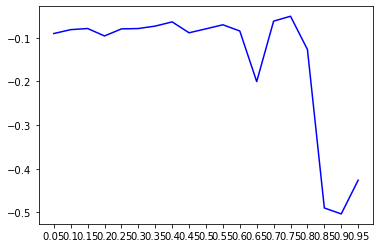

In [39]:
x = []
y = []
mid_time = dict()
for key, value in full_dict.items():
    for el in value:
        if key in mid_time:
            mid_time[key].append(el)
        else:
            mid_time[key] = [el]
mid_time = {key: np.mean(value) for key, value in mid_time.items()}
# plt.scatter(x, y, c ="red", alpha = 0.5)
# x = sorted(list(mid.keys()))
# y = [np.mean(mid[large]) for large in x]
# plt.plot(x, y, c ="red", label = 'Mean time for uncoded')

x = []
y = []
mid = dict()
for key, value in coded_dict.items():
    for el in value:
        large = len(json5.loads(key))
        if large > 10:
            x.append(el[0])
            y.append(el[1]/mid_time[key] - 1.0)
            if len(json5.loads(key)) in mid:
                mid[str(el[0])].append(el[1]/mid_time[key] - 1.0)
            else:
                mid[str(el[0])] = [el[1]/mid_time[key] - 1.0]
#plt.scatter(x, y, c ="blue", alpha = 0.5)
x = sorted(list(mid.keys()))
y = [np.mean(mid[large]) for large in x]
plt.plot(x, y, c ="blue", label = 'Mean time for coded')
